In [1]:
!nvidia-smi

Tue Mar 21 22:27:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!gdown 1h080QxKZA9FEH3ECVyxf2cb05mvp-Vlr

Downloading...
From: https://drive.google.com/uc?id=1h080QxKZA9FEH3ECVyxf2cb05mvp-Vlr
To: /content/archive (2).zip
100% 86.0M/86.0M [00:04<00:00, 20.5MB/s]


In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2

In [5]:
import zipfile
local_zip = '/content/archive (2).zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

(384, 512, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

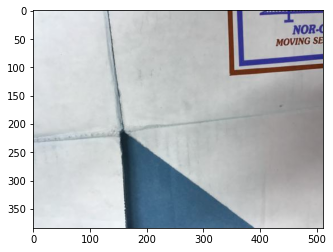

In [6]:
img = cv2.imread('/content/garbage classification/Garbage classification/cardboard/cardboard100.jpg')
print(img.shape)
plt.imshow(img)
plt.show

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/garbage classification/Garbage classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.


In [8]:
class_names = dataset.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[4 0 2 0 0 3 3 3 2 3 1 1 3 3 3 0 2 2 4 3 4 4 1 2 3 3 0 4 2 2 3 4]


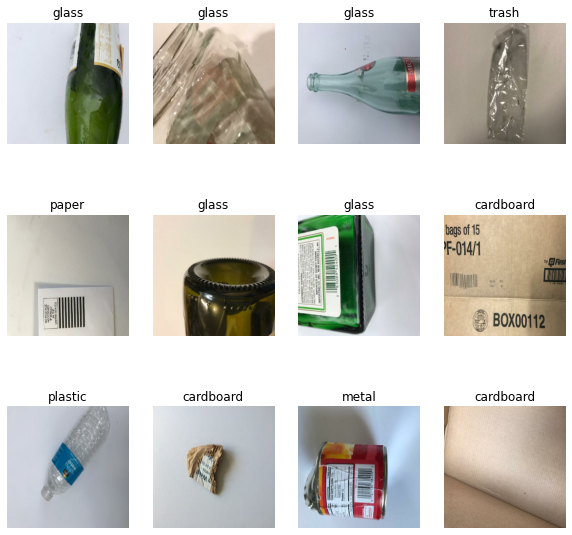

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
print(len(train_ds),len(val_ds),len(test_ds ))

63 7 9


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

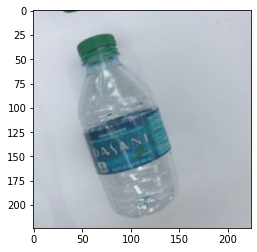

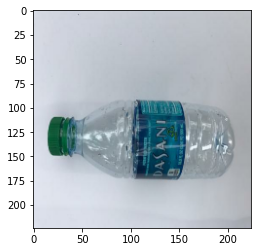

In [32]:
img = data_augmentation(imgs[0]).numpy().astype('uint8')

plt.imshow(img)
plt.show()
plt.imshow(imgs[0].numpy().astype('uint8'))

In [15]:
#def random_invert_img(x, p=0.5):
 # if  tf.random.uniform([]) < p:
  #  x = (255-x)
  #else:
   # x
  #return x

#def random_invert(factor=0.5):
 # return layers.Lambda(lambda x: random_invert_img(x, factor))

# random_invert = random_invert()

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(factor=0.7),
  #tf.keras.layers.RandomTranslation(0.4, 0.3, fill_mode='wrap'),
  #random_invert(0.4),
  

])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])




In [18]:

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse

baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(n_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_finetuned = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [19]:
model_finetuned.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
model_finetuned.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
EPOCHS = 15
history = model_finetuned.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/15
63/63 [==============================] - 38s 322ms/step - loss: 1.1639 - accuracy: 0.5858 - val_loss: 0.5633 - val_accuracy: 0.7991
Epoch 2/15
63/63 [==============================] - 16s 247ms/step - loss: 0.7126 - accuracy: 0.7381 - val_loss: 0.4326 - val_accuracy: 0.8661
Epoch 3/15
63/63 [==============================] - 17s 264ms/step - loss: 0.6148 - accuracy: 0.7733 - val_loss: 0.3678 - val_accuracy: 0.8839
Epoch 4/15
63/63 [==============================] - 15s 244ms/step - loss: 0.5568 - accuracy: 0.7961 - val_loss: 0.3350 - val_accuracy: 0.8839
Epoch 5/15
63/63 [==============================] - 16s 248ms/step - loss: 0.5063 - accuracy: 0.8155 - val_loss: 0.3246 - val_accuracy: 0.8750
Epoch 6/15
63/63 [==============================] - 16s 258ms/step - loss: 0.4607 - accuracy: 0.8373 - val_loss: 0.2673 - val_accuracy: 0.9152
Epoch 7/15
63/63 [==============================] - 16s 246ms/step - loss: 0.4504 - accuracy: 0.8338 - val_loss: 0.2616 - val_accuracy: 0.9286

In [23]:
# Generate Labels and Predictions 

labels = np.array([])
predictions = np.array([])

for x, y in test_ds:
  predict_x = model_finetuned.predict(x) 
  predictions = np.concatenate([predictions, np.argmax(predict_x, axis=1)])
  labels = np.concatenate([labels, y.numpy()])

labels

1/1 [==============================] - 0s 45ms/step


array([2., 1., 4., 5., 0., 2., 0., 4., 4., 4., 3., 0., 2., 1., 2., 1., 0.,
       0., 1., 0., 3., 0., 3., 4., 3., 1., 4., 3., 3., 2., 3., 0., 3., 1.,
       1., 1., 3., 5., 5., 4., 4., 2., 3., 3., 2., 4., 3., 2., 2., 4., 4.,
       4., 0., 0., 3., 1., 2., 4., 3., 0., 0., 0., 3., 2., 2., 0., 3., 4.,
       2., 5., 1., 1., 2., 0., 3., 4., 1., 3., 0., 0., 2., 3., 3., 3., 0.,
       0., 0., 5., 2., 2., 0., 4., 3., 4., 3., 2., 3., 0., 1., 3., 2., 4.,
       3., 1., 1., 3., 1., 0., 4., 3., 0., 2., 3., 0., 2., 3., 2., 3., 1.,
       0., 1., 1., 1., 0., 4., 0., 2., 3., 1., 0., 1., 3., 1., 4., 1., 4.,
       1., 2., 3., 2., 3., 3., 5., 3., 0., 2., 1., 4., 4., 1., 1., 4., 4.,
       5., 0., 4., 0., 4., 0., 4., 1., 3., 1., 4., 4., 5., 5., 1., 1., 4.,
       2., 4., 2., 1., 3., 1., 4., 2., 0., 1., 0., 0., 3., 2., 3., 4., 4.,
       0., 0., 4., 5., 4., 5., 3., 4., 0., 4., 2., 1., 2., 0., 2., 2., 4.,
       3., 4., 3., 1., 1., 4., 3., 2., 3., 2., 4., 3., 3., 4., 0., 4., 4.,
       4., 3., 1., 4., 3.

In [24]:

# show a nicely formatted classification report
print(classification_report(labels, predictions,
	target_names=class_names))


              precision    recall  f1-score   support

   cardboard       1.00      0.98      0.99        45
       glass       0.88      0.90      0.89        51
       metal       0.94      0.96      0.95        46
       paper       0.86      1.00      0.92        67
     plastic       0.96      0.85      0.90        65
       trash       1.00      0.71      0.83        14

    accuracy                           0.92       288
   macro avg       0.94      0.90      0.91       288
weighted avg       0.93      0.92      0.92       288



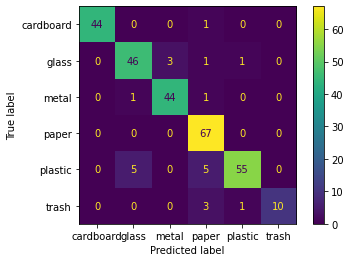

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions,
	                    labels=range(0, len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()

1/1 [==============================] - 0s 60ms/step
Class index: 0
True Class Name cardboard
False Class Name paper


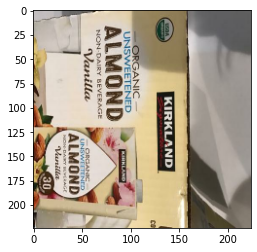

------------------------- 




In [26]:
imgs = []
labels = np.array([])
predictions = np.array([])

wrong_imgs = []
wrong_labels = []
wrong_preds = []
for x, y in test_ds:
  imgs.extend(list(x))
  predict_x = model_finetuned.predict(x) 
  predictions = np.concatenate([predictions, np.argmax(predict_x, axis=1)])
  labels = np.concatenate([labels, y.numpy()])

class_errors = 'cardboard'
class_index = class_names.index(class_errors)
print('Class index:', class_index)
for i in range(len(labels)):
  if class_index == int(labels[i]):
    if labels[i] != predictions[i]:
      print(f'True Class Name {class_names[int(labels[i])]}')
      print(f'False Class Name {class_names[int(predictions[i])]}')

      plt.imshow(imgs[i].numpy().astype('uint8'))
      plt.show()
      print('------------------------- \n\n')




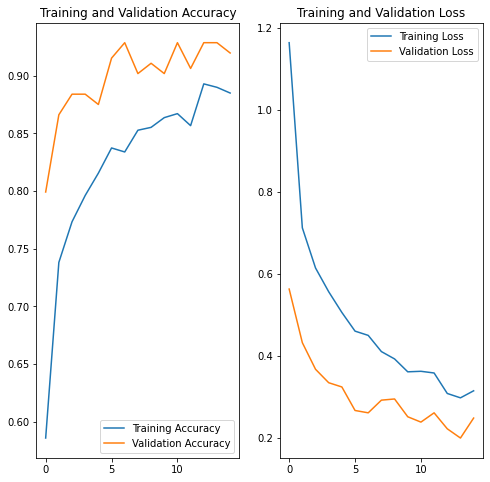

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: metal
1/1 [==============================] - 1s 810ms/step
predicted label: glass


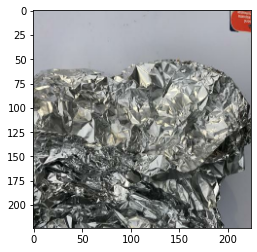

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions =  model_finetuned.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [30]:
def y_predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_finetuned.predict(img_array)

    y_pred = np.argmax(predictions[0])

    return y_pred


1/1 [==============================] - 0s 39ms/step


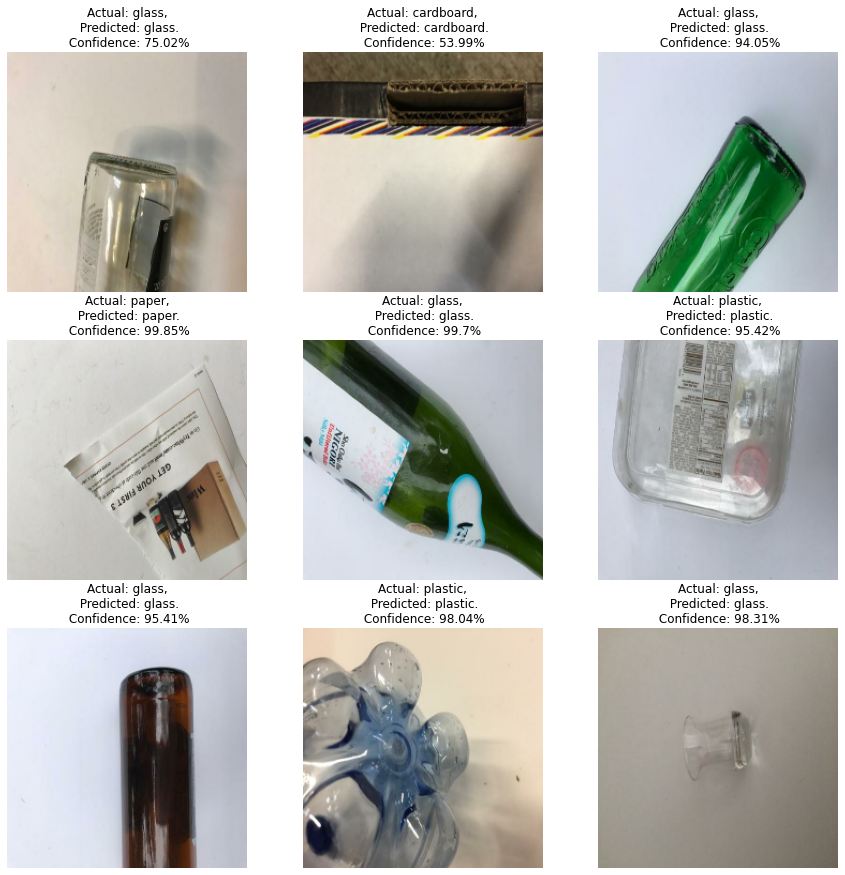

In [31]:
y_true = []
prediction =[]
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        y_pred= y_predict(model, images[i].numpy())
        y_true.append(labels)
        prediction.append(y_pred)
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")